In [27]:
# original notebook - https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\d91421\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
series = pd.Series.from_csv("daily-minimum-temperatures.csv",header=0)

C:\Users\d91421\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\core\series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [12]:
series.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

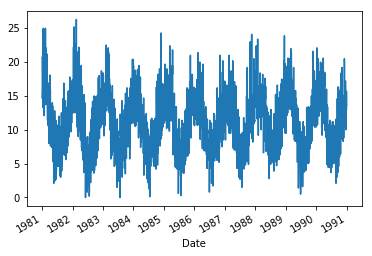

In [13]:
series.plot()
plt.show()

### Quick correlation

We can plot the observation at the previous time step (t-1) against the observation of the next time step (t+1) as a scatter plot. 

C:\Users\d91421\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """Entry point for launching an IPython kernel.


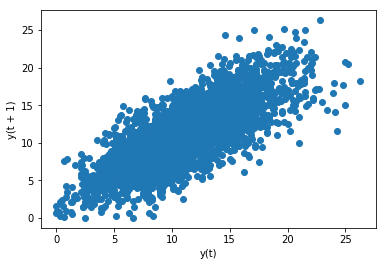

In [15]:
pd.tools.plotting.lag_plot(series)
plt.show()

We can see some kind of correlation, since there is a diagonal line depicting a tendency of the data points.

For a more precise calculation of the correlation one can calculate the Pearson correlation coefficient (done below).

In [16]:
values = pd.DataFrame(series.values)

In [20]:
print(values.head())
# concatenating t-1 and t values in new dataframe
dataframe = pd.concat([values.shift(1), values], axis=1)

      0
0  20.7
1  17.9
2  18.8
3  14.6
4  15.8


In [21]:
dataframe.columns = ['t-1','t+1']

In [22]:
dataframe.head()

t-1   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8

In [23]:
print(dataframe.corr())

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


### Autocorrelation plots

We can plot the correlation coefficiente for each lag variable, thus quickly giving an idea of which variables may be good candidates for use in a predictive model

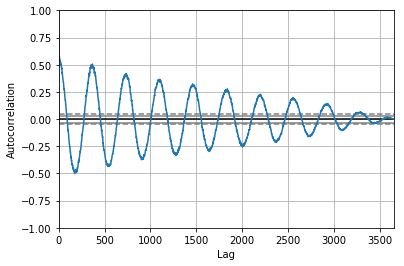

In [25]:
pd.plotting.autocorrelation_plot(series)
plt.show()

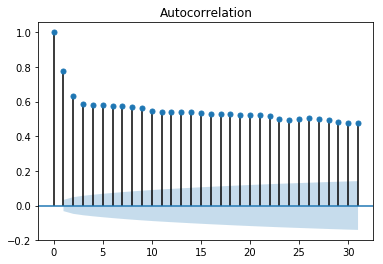

In [31]:
plot_acf(series, lags=31)
plt.show()

### Persistence model

Here we just want to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use would be to just persist the last observation. This provides a baseline of performance that we can use for comparisons.

We will use the last 7 observations as test data and the previous observations as training data

In [32]:
from sklearn.metrics import mean_squared_error

In [34]:
# create lagged dataset
values = pd.DataFrame(series.values)

In [35]:
dataframe = pd.concat([values.shift(1), values], axis=1)

In [36]:
dataframe.columns = ['t-1','t+1']

In [37]:
# split into train and test sets
X = dataframe.values

In [41]:
# other option would be to use
# from sklearn.model_selection import train_test_split
train, test = X[1:len(X) - 7],X[len(X) - 7:]

In [44]:
train_x, train_y = train[:,0],train[:,1]
test_x, test_y = test[:,0],test[:,1]

In [42]:
# persistence model
def model_persistence(x):
    return x

In [45]:
# walk-forward validation
predictions = list()
for x in test_x:
    yhat = model_persistence(x)
    predictions.append(yhat)

In [49]:
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 3.423


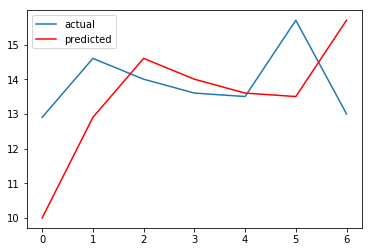

In [50]:
# plot predictions vs. expected
plt.plot(test_y, label='actual')
plt.plot(predictions, color='red',label='predicted')
plt.legend()
plt.show()

One can see that the model does exactly what it is asked to do, which is basically to predict the temperature of the next day as a repetition of the previous day, i.e. to lag it back one day.

### Autoregression model

An autoregression model is a linear regression model that uses lagged variables as input variables.

2 options to do the job:
    - Use scikit-learn LinearRegression class and manually specify the lag input variables to use
    - Use statsmodels autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. ==> NICE

In [92]:
# First approach - using AR straight up
# train autoregression
model = AR(train)

In [93]:
model_fit = model.fit()

In [95]:
print('Lag: %s' %model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 29
Coefficients: [  5.57543506e-01   5.88595221e-01  -9.08257090e-02   4.82615092e-02
   4.00650265e-02   3.93020055e-02   2.59463738e-02   4.46675960e-02
   1.27681498e-02   3.74362239e-02  -8.11700276e-04   4.79081949e-03
   1.84731397e-02   2.68908418e-02   5.75906178e-04   2.48096415e-02
   7.40316579e-03   9.91622149e-03   3.41599123e-02  -9.11961877e-03
   2.42127561e-02   1.87870751e-02   1.21841870e-02  -1.85534575e-02
  -1.77162867e-03   1.67319894e-02   1.97615668e-02   9.83245087e-03
   6.22710723e-03  -1.37732255e-03]


In [96]:
# Make predictions
predictions = model_fit.predict(start=len(train),
                                end=len(train) + len(test) - 1,
                               dynamic=False)

In [98]:
for i in range(len(predictions)):
    print('predicted:%f, expected:%f' %(predictions[i],test[i]))

predicted:11.871275, expected:12.900000
predicted:13.053794, expected:14.600000
predicted:13.532591, expected:14.000000
predicted:13.243126, expected:13.600000
predicted:13.091438, expected:13.500000
predicted:13.146989, expected:15.700000
predicted:13.176153, expected:13.000000


In [99]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' %error)

Test MSE: 1.502


[]

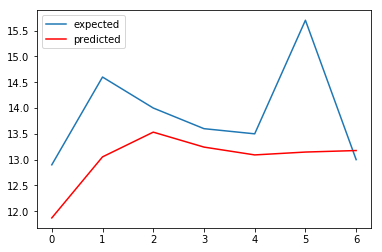

In [100]:
# plot results
plt.plot(test, label = 'expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.plot()

One can see that the results are not bad, but on day 5 there is a big discrepancy. Maybe we can do better.

In [101]:
# Second approach - manually using coefficients and fitting, keeping
# the history of the last 29 days and predicting manually

In [51]:
from statsmodels.tsa.ar_model import AR

In [56]:
# train autoregression
X = series.values

In [57]:
train, test = X[1:len(X)-7], X[len(X)-7:]

In [59]:
# train autoregression
model = AR(train)

In [60]:
model_fit = model.fit()

In [61]:
window = model_fit.k_ar

In [78]:
coef = model_fit.params
print(coef, len(coef))

[  5.57543506e-01   5.88595221e-01  -9.08257090e-02   4.82615092e-02
   4.00650265e-02   3.93020055e-02   2.59463738e-02   4.46675960e-02
   1.27681498e-02   3.74362239e-02  -8.11700276e-04   4.79081949e-03
   1.84731397e-02   2.68908418e-02   5.75906178e-04   2.48096415e-02
   7.40316579e-03   9.91622149e-03   3.41599123e-02  -9.11961877e-03
   2.42127561e-02   1.87870751e-02   1.21841870e-02  -1.85534575e-02
  -1.77162867e-03   1.67319894e-02   1.97615668e-02   9.83245087e-03
   6.22710723e-03  -1.37732255e-03] 30


In [79]:
# walk forward over time steps in test
history = train[len(train) - window:]

In [81]:
history = [history[i] for i in range(len(history))]

In [83]:
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length - window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1]*lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' %(yhat, obs))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' %error)

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


[]

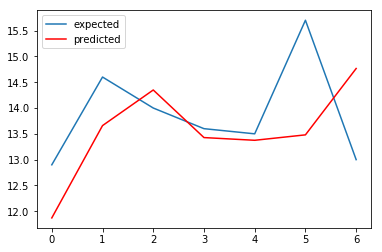

In [84]:
# plotting
plt.plot(test, label = 'expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.plot()